In [1]:
pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

1. Using Pytorch Library Define Generator, Define Discriminator, Define Loss Function,
Initialize Generator and Discriminator, GPU Setting, Configure Data Loader, Define Optimizers
and do Training.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os

# Définir le générateur
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Définir la fonction de perte
adversarial_loss = nn.BCELoss()

# Initialiser le générateur et le discriminateur
latent_dim = 100
img_shape = 3 * 64 * 64  # Taille de l'image (3 canaux RGB, 64x64)
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Configurer l'utilisation du GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Configurer le chargeur de données
batch_size = 64
data_folder = "/content/drive/MyDrive/dataset/Abstract_gallery"  # Modifier le chemin selon l'emplacement des images
dataset = ImageFolder(root=data_folder, transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Définir les optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fonction d'entraînement
def train(num_epochs):
    generator_losses = []
    discriminator_losses = []
    os.makedirs("images", exist_ok=True)  # Créer le dossier pour enregistrer les images générées
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1, device=device)
            fake = torch.zeros(imgs.size(0), 1, device=device)

            # Configurez les tenseurs de l'entrée
            real_imgs = imgs.view(imgs.size(0), -1).to(device)

            # Train the generator
            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.size(0), latent_dim, device=device)

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # Train the discriminator
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Enregistrer les pertes
            generator_losses.append(g_loss.item())
            discriminator_losses.append(d_loss.item())

            # Afficher la progression de l'entraînement
            if i % 100 == 0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                )

        # Sauvegarder les images générées après chaque époque
        if epoch % 10 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
    return generator_losses, discriminator_losses

# Lancer l'entraînement
num_epochs = 200
generator_losses, discriminator_losses = train(num_epochs)


[Epoch 0/200] [Batch 0/2] [D loss: 0.697002] [G loss: 0.664148]
[Epoch 1/200] [Batch 0/2] [D loss: 0.386472] [G loss: 0.982701]
[Epoch 2/200] [Batch 0/2] [D loss: 0.203747] [G loss: 1.370721]
[Epoch 3/200] [Batch 0/2] [D loss: 0.167190] [G loss: 1.439479]
[Epoch 4/200] [Batch 0/2] [D loss: 0.213997] [G loss: 1.164127]
[Epoch 5/200] [Batch 0/2] [D loss: 0.231873] [G loss: 1.125051]
[Epoch 6/200] [Batch 0/2] [D loss: 0.282017] [G loss: 1.039813]
[Epoch 7/200] [Batch 0/2] [D loss: 0.260254] [G loss: 1.061584]
[Epoch 8/200] [Batch 0/2] [D loss: 0.244408] [G loss: 1.102126]
[Epoch 9/200] [Batch 0/2] [D loss: 0.246587] [G loss: 1.062672]
[Epoch 10/200] [Batch 0/2] [D loss: 0.241204] [G loss: 1.043878]
[Epoch 11/200] [Batch 0/2] [D loss: 0.208945] [G loss: 1.155818]
[Epoch 12/200] [Batch 0/2] [D loss: 0.186561] [G loss: 1.273501]
[Epoch 13/200] [Batch 0/2] [D loss: 0.146721] [G loss: 1.496223]
[Epoch 14/200] [Batch 0/2] [D loss: 0.112429] [G loss: 1.773497]
[Epoch 15/200] [Batch 0/2] [D loss:

2. Evaluate the model by plotting (Loss, KL divergence, etc) (Generator and Discriminator),
what you conclude.

[Epoch 0/50] [Batch 0/5] [D loss: 0.695600] [G loss: 0.713356]
[Epoch 1/50] [Batch 0/5] [D loss: 0.179980] [G loss: 1.608789]
[Epoch 2/50] [Batch 0/5] [D loss: 0.260362] [G loss: 1.084819]
[Epoch 3/50] [Batch 0/5] [D loss: 0.284396] [G loss: 0.933988]
[Epoch 4/50] [Batch 0/5] [D loss: 0.314815] [G loss: 0.830572]
[Epoch 5/50] [Batch 0/5] [D loss: 0.210063] [G loss: 1.182403]
[Epoch 6/50] [Batch 0/5] [D loss: 0.137677] [G loss: 1.693038]
[Epoch 7/50] [Batch 0/5] [D loss: 0.085588] [G loss: 2.359746]
[Epoch 8/50] [Batch 0/5] [D loss: 0.077793] [G loss: 3.310006]
[Epoch 9/50] [Batch 0/5] [D loss: 0.056819] [G loss: 3.286199]
[Epoch 10/50] [Batch 0/5] [D loss: 0.056046] [G loss: 3.208001]
[Epoch 11/50] [Batch 0/5] [D loss: 0.044095] [G loss: 3.178663]
[Epoch 12/50] [Batch 0/5] [D loss: 0.052538] [G loss: 2.967821]
[Epoch 13/50] [Batch 0/5] [D loss: 0.053889] [G loss: 3.195796]
[Epoch 14/50] [Batch 0/5] [D loss: 0.110412] [G loss: 1.838215]
[Epoch 15/50] [Batch 0/5] [D loss: 1.745600] [G lo

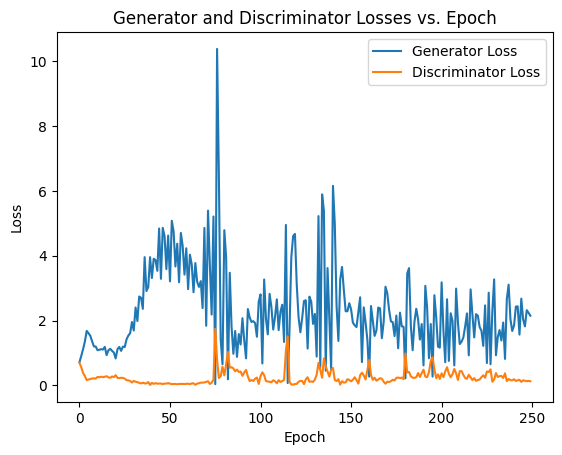

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt

# Définir le générateur
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Définir la fonction de perte
adversarial_loss = nn.BCELoss()

# Initialiser le générateur et le discriminateur
latent_dim = 100
img_shape = 3 * 64 * 64  # Taille de l'image (3 canaux RGB, 64x64)
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Configurer l'utilisation du GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Configurer le chargeur de données
batch_size = 64
data_folder = "/content/drive/MyDrive/dataset/Abstract_gallery"  # Modifier le chemin selon l'emplacement des images
dataset = ImageFolder(root=data_folder, transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Définir les optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fonction d'entraînement
def train(num_epochs):
    generator_losses = []
    discriminator_losses = []
    os.makedirs("images", exist_ok=True)  # Créer le dossier pour enregistrer les images générées
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1, device=device)
            fake = torch.zeros(imgs.size(0), 1, device=device)

            # Configurez les tenseurs de l'entrée
            real_imgs = imgs.view(imgs.size(0), -1).to(device)

            # Train the generator
            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.size(0), latent_dim, device=device)

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # Train the discriminator
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Enregistrer les pertes
            generator_losses.append(g_loss.item())
            discriminator_losses.append(d_loss.item())

            # Afficher la progression de l'entraînement
            if i % 100 == 0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                )

        # Sauvegarder les images générées après chaque époque
        if epoch % 10 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
    return generator_losses, discriminator_losses

# Lancer l'entraînement
num_epochs = 50
generator_losses, discriminator_losses = train(num_epochs)

# Fonction pour tracer les courbes de perte du générateur et du discriminateur
def plot_losses(generator_losses, discriminator_losses):
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses vs. Epoch')
    plt.legend()
    plt.show()

# Tracer les courbes de perte du générateur et du discriminateur
plot_losses(generator_losses, discriminator_losses)


3. Generate the new Data and compare their quality to the original ones.

In [ ]:
from torchvision.transforms.functional import to_pil_image

# Visualiser les images originales et les images générées
def compare_images(original_images, generated_images, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

    for i in range(num_images):
        # Afficher les images originales
        axes[0, i].imshow(to_pil_image(original_images[i].cpu()))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        # Redimensionner et afficher les images générées
        generated_image = generated_images[i].cpu()
        if len(generated_image.shape) == 3:
            axes[1, i].imshow(to_pil_image(generated_image))
        elif len(generated_image.shape) == 2:
            axes[1, i].imshow(to_pil_image(generated_image.squeeze()))
        else:
            raise ValueError(f"Unexpected dimensions: {generated_image.shape}")
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')

    plt.show()

# Comparer les images originales et les images générées
compare_images(original_images, generated_images)
